## Lennard Jones Potential

test output of Lennard Jones Potential

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import particlesim.api

* Create a System with two particles and a boxlength of ten
* Let particles approach from each side of the box in 1 dimension and calculate Lennard Jones Potential for each step

In [77]:
def particle_config(box_size = 10., charges= 0, sigma = 1.0, epsilon = 1.0, r_lim = 0.95, lennard_jones = True, coulomb = False):
    particle_1 = [0.,0,0]
    particle_2 = [box_size - r_lim,0,0]
    particle_positions = np.array([particle_1, particle_2])
    system_configuration = particlesim.api.SystemConfiguration(particle_positions,charges=charges, sigmas = sigma, epsilons = epsilon,
                                                               box_size = 10.)
    distance, pot = [], []
    while particle_positions[0][0] <= particle_positions[1][0]-r_lim:
        particle_positions[0][0] += 0.05
        r = np.linalg.norm(particle_positions[0] - particle_positions[1])
        if r > box_size/2:
            r -= box_size
        distance.append(r)
        pot.append(system_configuration.potential(xyz_trial = particle_positions,
                                                  lennard_jones=lennard_jones, coulomb = coulomb))
 
    distance = distance[int(len(distance)/2):]+distance[:int(len(distance)/2)]
    pot = pot[int(len(pot)/2):] + pot[:int(len(pot)/2)]
    return distance[::-1], pot[::-1]

### Parameter for Na+ and Cl-

In [78]:
sigma_na = 1.21496
epsilon_na = 0.0469
q_na = +1.0

sigma_cl = 2.02234 
epsilon_cl = 0.15
q_cl = -1.0

sigmas=[sigma_na, sigma_cl]
epsilons = [epsilon_na, epsilon_cl]
charges = [q_na, q_cl]

### Calculate Lennard Jones Potential of Na+ and Cl-

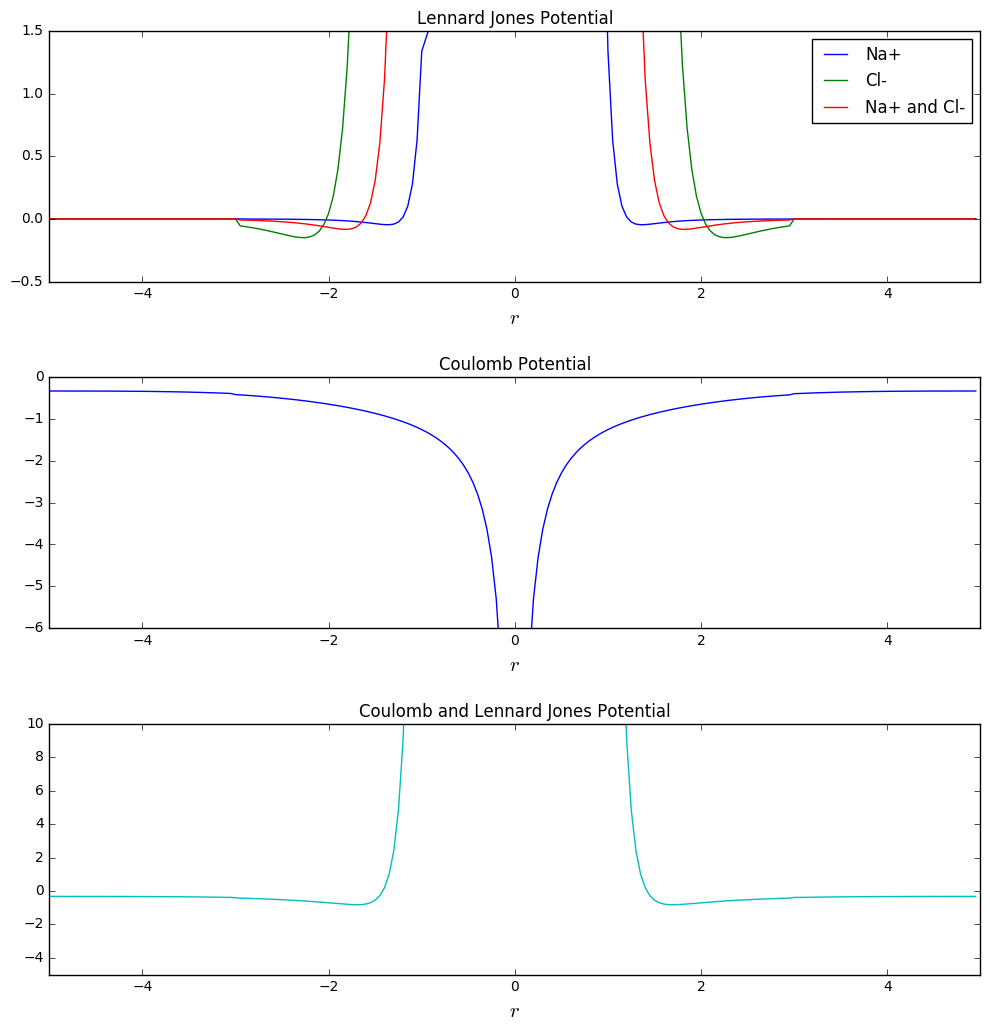

In [79]:
distance_na, pot_na = particle_config(sigma=sigma_na, epsilon=epsilon_na, lennard_jones=True, coulomb=False)
distance_cl, pot_cl = particle_config(sigma=sigma_cl, epsilon=epsilon_cl, lennard_jones=True, coulomb=False)
distance_mix, pot_mix = particle_config(sigma=sigmas,epsilon=epsilons, lennard_jones=True, coulomb=False)


distance_coulomb, pot_coulomb = particle_config(charges=charges, sigma=sigmas, epsilon=epsilons, r_lim=0.1,
                                                lennard_jones= False, coulomb=True)

distance_LJ_C, pot_LJ_C = particle_config(charges=charges, sigma=sigmas, epsilon=epsilons, r_lim=0.7,
                                                lennard_jones= True, coulomb=True)

fig, axes = plt.subplots(3,1, figsize=(10,10))
fig.tight_layout(h_pad=5)
axes[0].plot(distance_na,pot_na, label='Na+')
axes[0].plot(distance_cl,pot_cl, label='Cl-')
axes[0].plot(distance_mix,pot_mix, label='Na+ and Cl-')
axes[0].set_xlabel(r"$r$", fontsize=15)
axes[0].set_xlim([-5,5])
axes[0].set_ylim([-0.5, 1.5])
axes[0].set_title(r"Lennard Jones Potential")
axes[0].legend()

axes[1].plot(distance_coulomb, pot_coulomb, label='q_Na = +1.0, q_Cl = -1.0')
axes[1].set_xlabel(r"$r$", fontsize=15)
axes[1].set_xlim([-5,5])
axes[1].set_ylim([-6, 0])
axes[1].set_title(r"Coulomb Potential")

axes[2].plot(distance_LJ_C, pot_LJ_C,'c', label='q_Na = +1.0, q_Cl = -1.0')
axes[2].set_xlabel(r"$r$", fontsize=15)
axes[2].set_xlim([-5,5])
axes[2].set_ylim([-5, 10])
axes[2].set_title(r"Coulomb and Lennard Jones Potential")


In [13]:
def particle_config_next(box_size = 10., charges= 0, sigma = 1.0, epsilon = 1.0, r_lim = 0.95,
                         lennard_jones = True, coulomb = False):
    particle_1 = [0.,0.4,.2]
    particle_2 = [0.1,.2,.1]
    particle_positions = np.array([particle_1, particle_2])
    return particlesim.api.SystemConfiguration(particle_positions,charges=charges, sigmas = sigma, epsilons = epsilon,
                                                               box_size = 10.)

In [8]:
n = 100
g = np.linspace(0.0, 10.0, n, endpoint=False)
rho = np.zeros(shape=(n, n, n), dtype=np.float64)
rho[0, 4, 2] = 1.0
rho[1, 2, 1] = -1.0
h = g[1]-g[0]

system_config = particle_config_next(charges=charges)
pot_ewald = system_config.potential(xyz_trial = system_config.xyz,
                                                  lennard_jones=False, coulomb = True)
print(pot_ewald)

-4.08489133384


In [57]:
def sor_3d(rho, maxerr=1.0E-8, maxiter=1000, w=None):
    r"""Solve the 3D Poisson equation using the successive overrelaxation method.
    
    Parameters
    ----------
    rho : numpy.ndarray(shape=(n, n, n))
        The charge density grid.
    maxerr : float, optional, default=1.eE-8
        The convergence criterion.
    maxiter : int, optional, default=1000
        The number of iterations.
    w : float, optional, default=None
        Overwrite the automatically computed SOR parameter.
    
    Returns
    -------
    numpy.ndarray(shape=rh,shape, dtype=rho.dtype)
        The potential grid.
    
    """
    if rho.ndim != 3 or rho.shape[0] != rho.shape[1] != rho.shape[2]:
        raise ValueError("rho must be of shape=(n, n, n)")
    phi = np.zeros(shape=rho.shape, dtype=rho.dtype)
    nx, ny, nz = rho.shape
    if w is None:
        w = 2.0 / (1.0 + np.pi / float(nx))
    errors = []
    for iteration in range(maxiter):
        error = 0.0
        for x in range(nx):
            for y in range(ny):
                for z in range(nz):
                    if (x + y + z) % 2 == 0: continue
                    phi_xyz = (
                        phi[(x - 1) % nx, y, z] + \
                        phi[(x + 1) % nx, y, z] + \
                        phi[x, (y - 1) % ny, z] + \
                        phi[x, (y + 1) % ny, z] + \
                        phi[x, y, (z - 1) % nz] + \
                        phi[x, y, (z + 1) % nz] + \
                        rho[x, y, z]) / 6.0
                    phi[x, y, z] = (1.0 - w) * phi[x, y, z] + w * phi_xyz
                    error += (phi[x, y, z] - phi_xyz)**2
        for x in range(nx):
            for y in range(ny):
                for z in range(nz):
                    if (x + y + z) % 2 != 0: continue
                    phi_xyz = (
                        phi[(x - 1) % nx, y, z] + \
                        phi[(x + 1) % nx, y, z] + \
                        phi[x, (y - 1) % ny, z] + \
                        phi[x, (y + 1) % ny, z] + \
                        phi[x, y, (z - 1) % nz] + \
                        phi[x, y, (z + 1) % nz] + \
                        rho[x, y, z]) / 6.0
                    phi[x, y, z] = (1.0 - w) * phi[x, y, z] + w * phi_xyz
                    error += (phi[x, y, z] - phi_xyz)**2
        errors.append(np.sqrt(error))
        if error < maxerr:
            print("convergence reached after %d steps! error: %.e" % (iteration + 1, error))
            return phi, errors
    raise RuntimeError("not converged after %d steps! last error: %e" % (maxiter, error))

In [75]:
max_charge = 1.0
g = np.linspace(0.0, 10.0, 10, endpoint=False)
number_of_particles = 10
box_size = 10.0
charges_half = np.random.randint(-max_charge, max_charge, (number_of_particles + 1) // 2 )
charges = np.append(charges_half, -1 * charges_half)
charges = charges[:number_of_particles] #check that nr of charges is correct
if not np.sum(charges) == 0:
    raise ValueError('total charge has to be zero')
positions = np.random.rand(number_of_particles,3) * box_size

positions = positions.astype(int)
#print(charges)
#print(positions)
rho = np.zeros(shape=(10,10,10), dtype=np.float64)
for i in range(number_of_particles):
#    for j in range(3):
    rho[positions[i][0],positions[i][1],positions[i][2]] = charges[i]
phi, errors = sor_3d(rho*(g[1]-g[0])**3, maxiter= 1000)

convergence reached after 13 steps! error: 7e-09
